In [ ]:
import os
os.chdir('/Users/rv/Projects/7CS074') # Change to the project root directory

import pandas as pd

import global_vars 

from models import get_type_models

In [2]:
# First we will check and run the preprocessing script
# In case this is already done, this will not overwrite existing files
from preprocessing import process_raw_multiple_data_files

process_raw_multiple_data_files()

In [ ]:
if not os.path.exists(global_vars.DATASET_CLEAN_FILE_PATH):
    raise FileNotFoundError(f"Dataset not found at {global_vars.DATASET_CLEAN_FILE_PATH}. Please ensure the dataset is placed correctly.")

df = pd.read_csv(global_vars.DATASET_CLEAN_FILE_PATH, sep=',', engine='python') # read with proper delimiter handling, and with python engine always
if df.empty:
    raise ValueError("Loaded dataset is empty. Please check the dataset file.")

print(f"Data loaded successfully from {global_vars.DATASET_CLEAN_FILE_PATH}.")

Data loaded successfully from /Users/rv/Projects/7CS074/data/clean/cleaned_dataset.csv.


In [4]:
from sklearn.discriminant_analysis import StandardScaler

candidate_models = get_type_models('clustering', clusters=6, random_state=42)

X = df[global_vars.CLUSTERING_FEATURES].copy()

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clustering_results = {}

In [5]:
from clustering_labels import assign_cluster_labels
from evaluation import calculate_silhouette_score

for name, model in candidate_models.items():
	# Fit the model
	labels = model.fit_predict(X_scaled)
	
	# Add cluster labels to dataframe
	df_clustered = df.copy()
	df_clustered['cluster'] = labels
	
	# Assign meaningful labels
	df_clustered, label_map = assign_cluster_labels(df_clustered, 'cluster')
	
	unique_labels = len(set(labels))
	if unique_labels > 1:
		silhouette = calculate_silhouette_score(X_scaled, labels)
	else:
		silhouette = None
	
	clustering_results[name] = {
		'model': model,
		'labels': labels,
		'df_clustered': df_clustered,
		'label_map': label_map,
		'silhouette_score': silhouette,
		'scaler': scaler,
		'features': global_vars.CLUSTERING_FEATURES,
		'n_clusters': unique_labels
	}

In [6]:
for name, results in clustering_results.items():
    print(f"\n{name.upper()}:")
    print(f"  Number of clusters: {results['n_clusters']}")
    if results['silhouette_score'] is not None:
        print(f"  Silhouette Score: {results['silhouette_score']:.3f}")
    else:
        print(f"  Silhouette Score: Not available")
    
    print(f"\n  Cluster Distribution:")
    if 'cluster_label' in results['df_clustered'].columns:
        distribution = results['df_clustered']['cluster_label'].value_counts()
        for label, count in distribution.items():
            print(f"    {label}: {count} cars")


K-MEANS:
  Number of clusters: 6
  Silhouette Score: 0.258

  Cluster Distribution:
    Family SUV: 20245 cars
    Efficient: 7405 cars
    Performance: 5088 cars
    Budget: 1524 cars


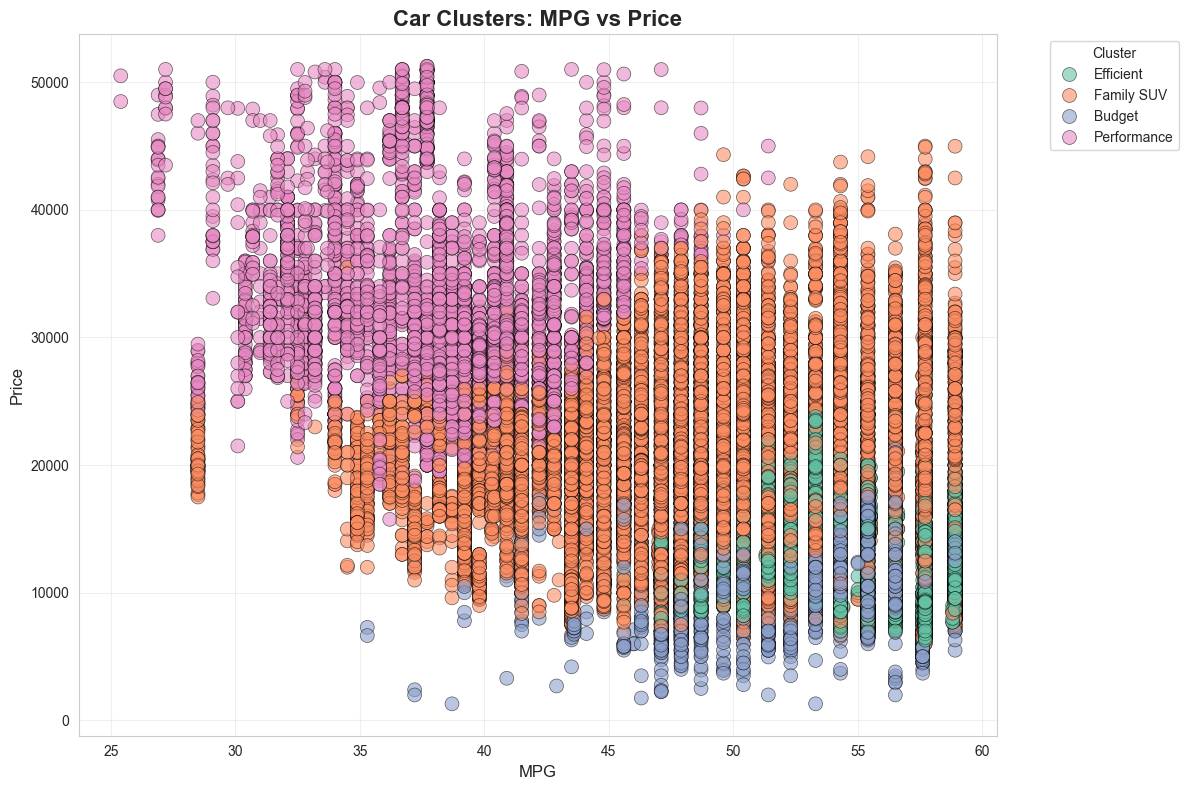

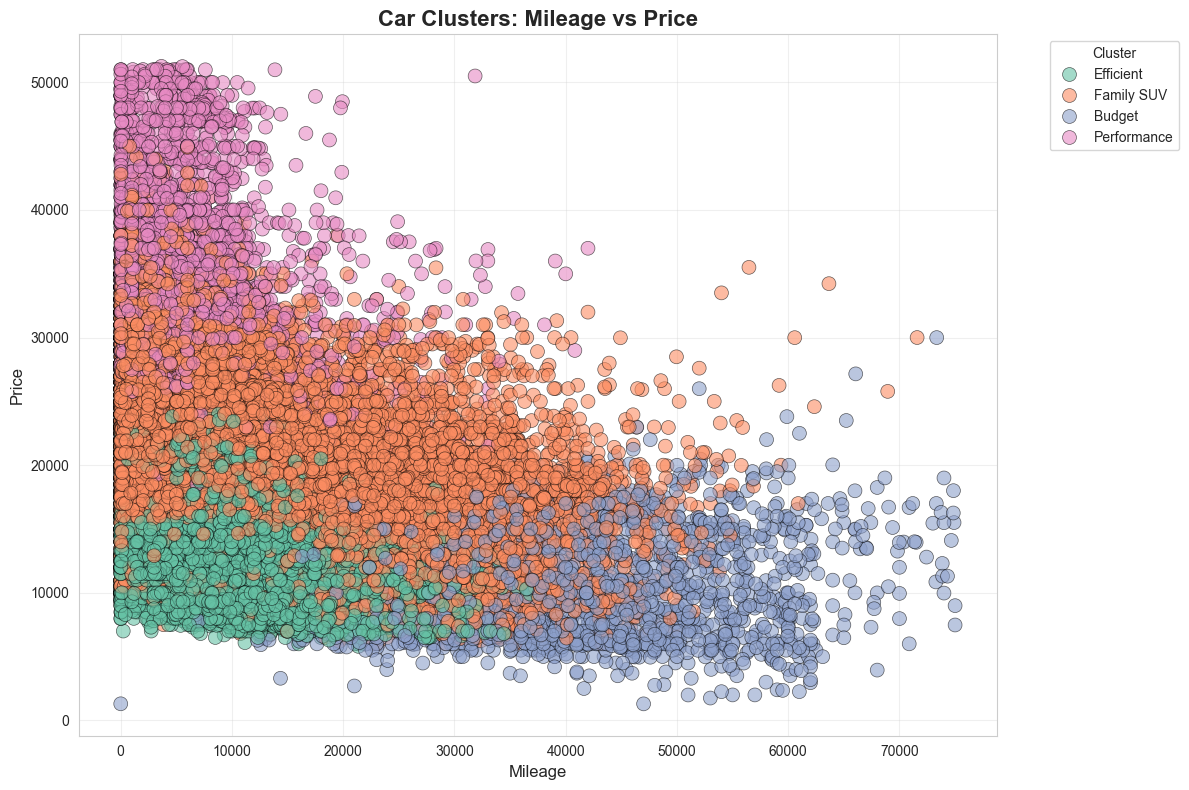

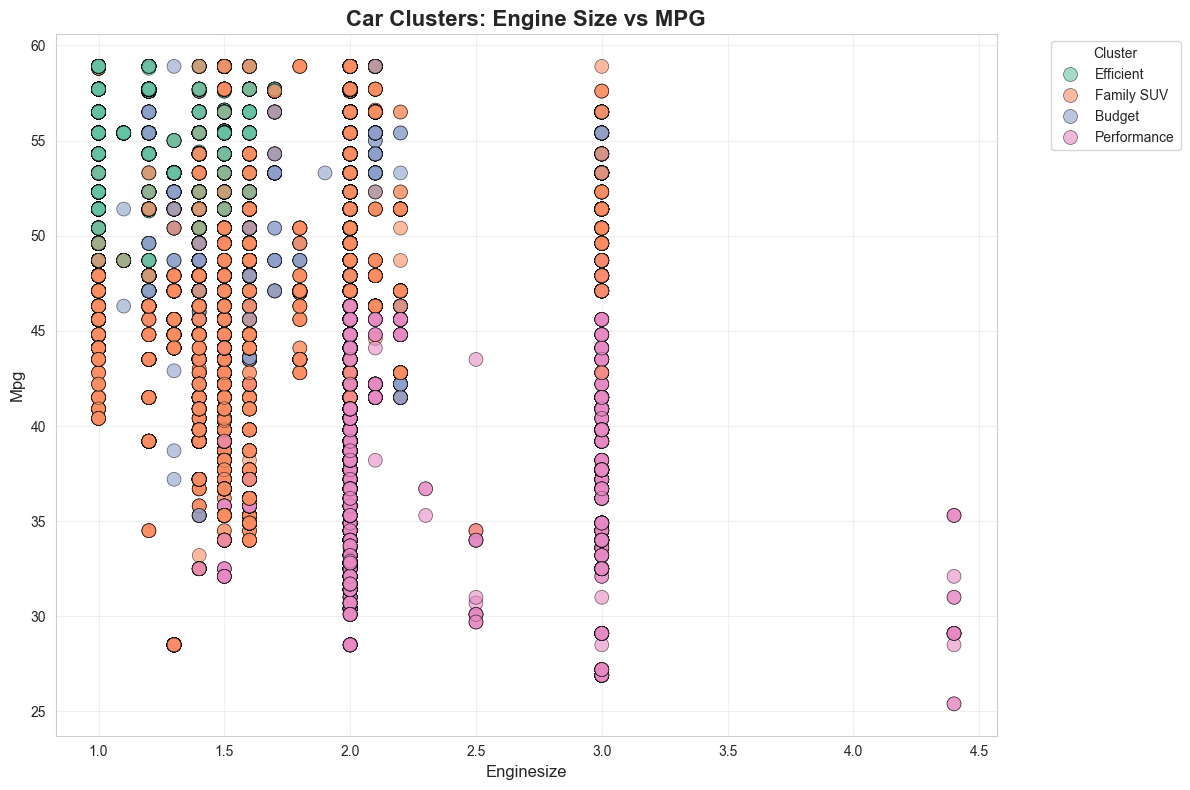

In [7]:
# Compare clustering algorithms
from visualisation import plot_clusters

# Detailed analysis of best clustering algorithm (KMeans) - the only one currently
best_clustering = clustering_results['k-means']
df_clustered = best_clustering['df_clustered']

# Cluster scatter plots with different feature combinations
plot_clusters(
    df_clustered, 
    cluster_col='cluster_label',
    x_col='mpg', 
    y_col='price',
    title='Car Clusters: MPG vs Price'
)

plot_clusters(
    df_clustered,
    cluster_col='cluster_label',
    x_col='mileage',
    y_col='price',
    title='Car Clusters: Mileage vs Price'
)

plot_clusters(
    df_clustered,
    cluster_col='cluster_label',
    x_col='engineSize',
    y_col='mpg',
    title='Car Clusters: Engine Size vs MPG'
)
